In [1]:
import cv2 as cv
import numpy as np
import os
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
from skimage.measure import shannon_entropy
import pyfeats
import pandas as pd
import multiprocessing as mlp
import math
import feature_extraction as fe

## Define Feature Extraction functions

### Read dataset images

In [2]:
def read_images(folder = "dataset/train",
                classes = [
                            "normal",
                            "fatty",
#                             "cirrhosis"
                        ]):
    image_names = {}
    images = []
    # Get all image names in folders
    for cls in classes:
        image_names[cls] = os.listdir(f'{folder}/{cls}')

    # read all images to list
    for cls in classes:
        for name in image_names[cls]:
            img = cv.imread(f'{folder}/{cls}/{name}', cv.IMREAD_GRAYSCALE)
            images.append((img,cls))
    return images

### Extract ROIs from image

In [3]:
def extract_roi(img, start , size = (32,32)):
    roi = img[start[0]:start[0]+size[0],start[1]:start[1]+size[1]]
    mask = np.zeros(img.shape)
    mask[start[0]:start[0]+size[0],start[1]:start[1]+size[1]] = 1
    return roi, mask

### Extract Features from ROIs

In [4]:
def feature_extraction(img):
    roi_pos = [
        (160,230),
        (118,224),
        (241,151),
        (120,420),
        (170,300),
        (400,200),
        (300,120),
        (240,240),
        (360,160)
    ]
    
    roi_mask_arr = []
    for pos in roi_pos:
        roi_mask_arr.append(extract_roi(img, pos))
    
    # 0 45 90 135 degrees
    angles = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]
    
    da_dict = {
        0: "d1_0",
        1: "d1_45",
        2: "d1_90",
        3: "d1_135",
        
        4: "d2_0",
        5: "d2_45",
        6: "d2_90",
        7: "d2_135",
        
        8: "d3_0",
        9: "d3_45",
        10: "d3_90",
        11: "d3_135",
        
    }
    
    feat_arr = []
    for roi, mask in roi_mask_arr:
        if 0 in roi or roi.shape != (32,32) or 0 in image.shape:
            continue
        features = {}
        
        glcm_mtx = greycomatrix(roi, distances = [1,2,3], angles = angles, levels = 256)
        con = greycoprops(glcm_mtx, 'contrast').flatten()
        hom = greycoprops(glcm_mtx, 'homogeneity').flatten()
        en = greycoprops(glcm_mtx, 'energy').flatten()
        corr = greycoprops(glcm_mtx, 'correlation').flatten()
        
        for j in range(len(da_dict)):
            features[f'contrast_{da_dict[j]}'] = con[j]
            features[f'homogeneity_{da_dict[j]}'] = hom[j]
            features[f'energy_{da_dict[j]}'] = en[j]
            features[f'correlation_{da_dict[j]}'] = corr[j]
            
        features[f'entropy'] = shannon_entropy(roi)

        feat, labels = pyfeats.glrlm_features(img, mask, 256)
        for i in range(len(labels)):
            features[labels[i]] = feat[i]
#         glrlm = {l : f for l,f in zip(labels,feat)}
#         features[f'longRunEmphasis'] = glrlm['GLRLM_LongRunEmphasis']
#         features[f'runPercentage'] = glrlm['GLRLM_RunPercentage']
        
        feat_arr.append(features)
        
    return feat_arr

### Construct dataframe from ROI features

In [5]:
def build_dataframe(images):
    # dataframe consists of features of 1 ROI per image
    # column name roiNum_feature
    data = pd.DataFrame()

    for img, cls in images:
        feat_arr = feature_extraction(img)
        for row in feat_arr:
            row['target'] = cls
            data = data.append(row,ignore_index=True)
    return data

### Construct dataframe using multiprocessing
### Reduced runtime by 82%

In [6]:
def build_with_mlp(images, n=9): 
    pool = mlp.Pool(n)
    results = pool.map(fe.build_dataframe,np.array_split(images,n))
    return results

## Feature Analysis and Selection

### Read data

In [7]:
%%time

# images = fe.read_images()
# mlp_data = build_with_mlp(images)
# data = pd.DataFrame()
# for frame in mlp_data:
#     data = data.append(frame)

# images = read_images()

# data = build_dataframe(images)

# data40 = pd.read_csv('dataset/roi_40img_9_roi_3d_4a_32p.csv')
# data55 = pd.read_csv('dataset/roi_55img_9_roi_3d_4a_32p.csv')
# data = data40.append(data55, ignore_index=True)

data = pd.read_csv('dataset/roi_95img_9_roi_glrlm_32p.csv')

# data = data[data['contrast_d1_0'] != 0]

data.describe()

Wall time: 97.7 ms


,GLRLM_GrayLevelNo-Uniformity,GLRLM_HighGrayLevelRunEmphasis,GLRLM_LongRunEmphasis,GLRLM_LongRunHighGrayLevelEmphasis,GLRLM_LongRunLowGrayLevelEmphasis,GLRLM_LowGrayLevelRunEmphasis,GLRLM_RunLengthNonUniformity,GLRLM_RunPercentage,GLRLM_Short owGrayLevelEmphasis,GLRLM_ShortRunEmphasis,...,homogeneity_d1_45,homogeneity_d1_90,homogeneity_d2_0,homogeneity_d2_135,homogeneity_d2_45,homogeneity_d2_90,homogeneity_d3_0,homogeneity_d3_135,homogeneity_d3_45,homogeneity_d3_90
count,652.000000,652.000000,652.000000,652.000000,652.0,6.520000e+02,652.000000,652.000000,6.520000e+02,652.000000,...,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000
mean,1921.510314,5703.885505,1.497804,10050.854025,1.0,2.438859e+13,122793.067413,0.849111,2.438859e+13,0.940991,...,0.175332,0.150242,0.159784,0.136342,0.175332,0.110708,0.127782,0.110149,0.121330,0.105989
std,508.112764,2334.945434,0.301293,2726.255341,0.0,3.760323e+13,19311.223327,0.139700,3.760323e+13,0.023467,...,0.101357,0.080165,0.091378,0.073002,0.101357,0.067374,0.075139,0.068581,0.073476,0.069619
min,1061.252459,1464.268635,1.284691,4608.793048,1.0,1.240330e+12,102848.447946,0.707023,1.240330e+12,0.886683,...,0.054134,0.059946,0.053075,0.046886,0.054134,0.039637,0.043536,0.034124,0.037732,0.031738
25%,1517.656602,3934.288885,1.303543,7965.404175,1.0,1.417345e+12,104711.180655,0.711509,1.417345e+12,0.922127,...,0.100607,0.091102,0.085333,0.074899,0.100607,0.063334,0.070887,0.059471,0.069231,0.057091
50%,1865.455909,5411.884481,1.403044,9602.318062,1.0,2.684349e+13,116592.843012,0.875869,2.684349e+13,0.941259,...,0.149665,0.120711,0.124799,0.123777,0.149665,0.083633,0.096040,0.091301,0.095371,0.078179
75%,2301.639241,7577.824106,1.559396,11944.978200,1.0,3.024732e+13,137380.052461,0.984368,3.024732e+13,0.962491,...,0.219634,0.190545,0.218905,0.175523,0.219634,0.137679,0.170120,0.135909,0.151690,0.134200
max,3590.511843,11461.201056,3.137791,18661.048823,1.0,2.950940e+14,157672.709448,1.079653,2.950940e+14,0.965812,...,0.576049,0.515312,0.565827,0.457325,0.576049,0.417440,0.480954,0.443175,0.436596,0.401612


In [8]:
# data.to_csv("dataset/roi_95img_9_roi_glrlm_32p.csv",index = False)

### Mutual information score

In [9]:
from sklearn.preprocessing import StandardScaler

X = data.copy()
y = X.pop('target')

std = StandardScaler()
std.fit(X)
X = pd.DataFrame(std.transform(X),columns=X.columns)

In [10]:
X.describe()

,GLRLM_GrayLevelNo-Uniformity,GLRLM_HighGrayLevelRunEmphasis,GLRLM_LongRunEmphasis,GLRLM_LongRunHighGrayLevelEmphasis,GLRLM_LongRunLowGrayLevelEmphasis,GLRLM_LowGrayLevelRunEmphasis,GLRLM_RunLengthNonUniformity,GLRLM_RunPercentage,GLRLM_Short owGrayLevelEmphasis,GLRLM_ShortRunEmphasis,...,homogeneity_d1_45,homogeneity_d1_90,homogeneity_d2_0,homogeneity_d2_135,homogeneity_d2_45,homogeneity_d2_90,homogeneity_d3_0,homogeneity_d3_135,homogeneity_d3_45,homogeneity_d3_90
count,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,652.0,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,...,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02,6.520000e+02
mean,-9.920490e-16,2.561005e-16,7.059792e-16,7.029142e-16,0.0,-4.030518e-16,-4.665661e-17,6.044926e-16,-4.030518e-16,3.193764e-15,...,-1.214732e-16,1.255626e-16,1.760691e-16,2.519287e-16,-1.214732e-16,4.664597e-16,6.598867e-17,-2.715960e-17,4.099481e-17,-2.937323e-17
std,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,0.0,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,...,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00,1.000768e+00
min,-1.694345e+00,-1.817118e+00,-7.078702e-01,-1.997700e+00,0.0,-6.160651e-01,-1.033592e+00,-1.017872e+00,-6.160651e-01,-2.315938e+00,...,-1.196665e+00,-1.127238e+00,-1.168662e+00,-1.226337e+00,-1.196665e+00,-1.055681e+00,-1.122055e+00,-1.109402e+00,-1.138637e+00,-1.067356e+00
25%,-7.954214e-01,-7.584568e-01,-6.452527e-01,-7.655376e-01,0.0,-6.113540e-01,-9.370597e-01,-9.857371e-01,-6.113540e-01,-8.044692e-01,...,-7.378117e-01,-7.382883e-01,-8.153826e-01,-8.423091e-01,-7.378117e-01,-7.036833e-01,-7.577775e-01,-7.395231e-01,-7.096094e-01,-7.029019e-01
50%,-1.104035e-01,-1.251529e-01,-3.147510e-01,-1.646509e-01,0.0,6.533430e-02,-3.213149e-01,1.916862e-01,6.533430e-02,1.143201e-02,...,-2.534291e-01,-3.686520e-01,-3.831509e-01,-1.722470e-01,-2.534291e-01,-4.021625e-01,-4.227698e-01,-2.750439e-01,-3.535709e-01,-3.997687e-01
75%,7.486936e-01,8.031782e-01,2.045833e-01,6.953048e-01,0.0,1.559233e-01,7.559430e-01,9.689442e-01,1.559233e-01,9.168658e-01,...,4.374224e-01,5.031397e-01,6.474860e-01,5.371213e-01,4.374224e-01,4.006238e-01,5.638855e-01,3.759014e-01,4.135126e-01,4.055183e-01
max,3.287229e+00,2.467610e+00,5.447335e+00,3.160674e+00,0.0,7.204521e+00,1.807572e+00,1.651532e+00,7.204521e+00,1.058503e+00,...,3.956541e+00,4.557484e+00,4.446952e+00,4.400305e+00,3.956541e+00,4.556168e+00,4.703835e+00,4.859705e+00,4.294002e+00,4.249518e+00


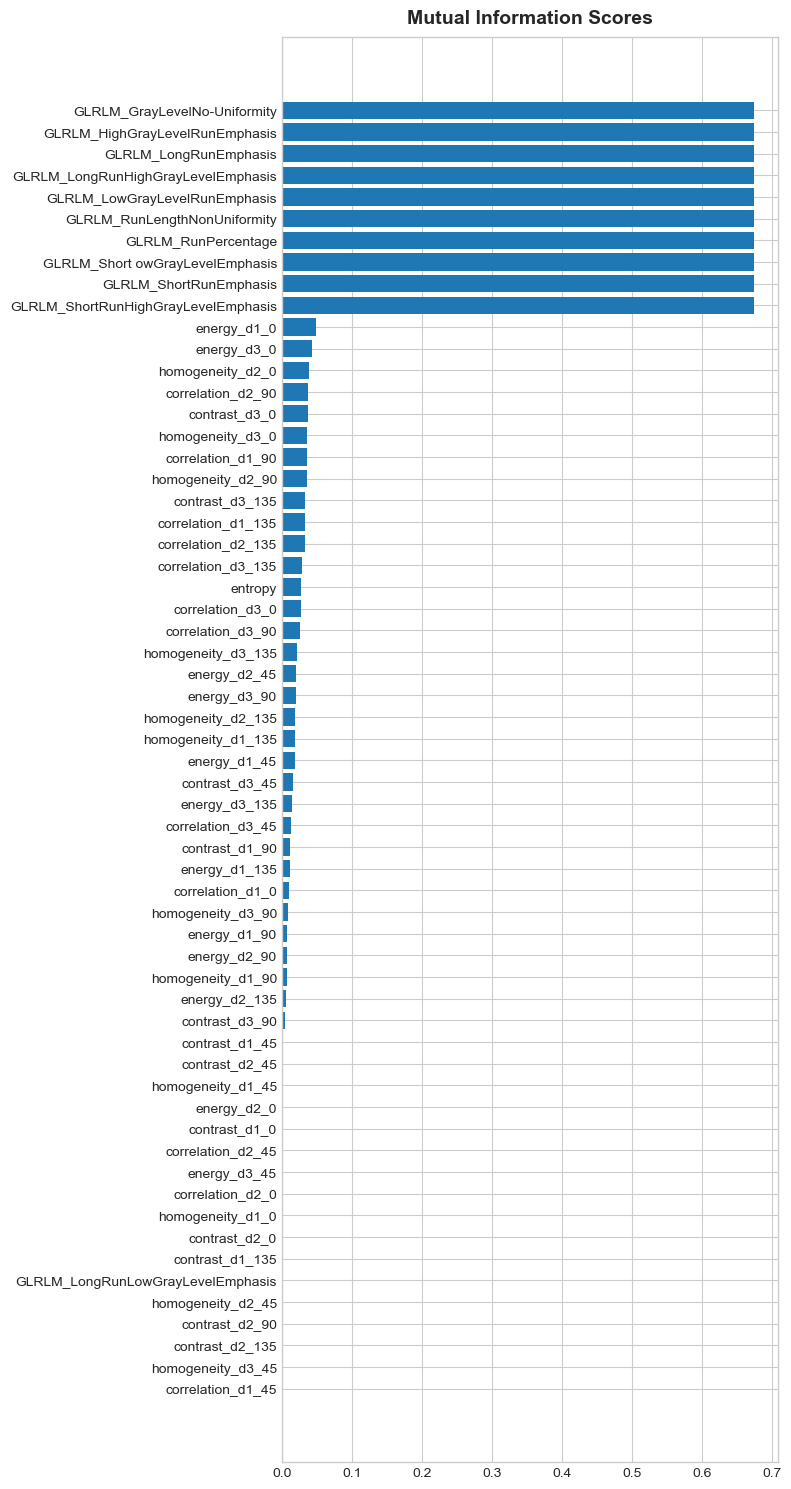

In [11]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def make_mi_scores(X, y):
    X = X.copy()
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
mi_scores = make_mi_scores(X, y)

plt.figure(dpi=100, figsize=(8, 15))
plot_mi_scores(mi_scores)

## Train Predictions and Scores

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,20],
    'criterion' :['gini', 'entropy']
}

In [13]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [8, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [14]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 500}

In [15]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=20, criterion='entropy')

rfc1.fit(X, y)

y_pred = rfc1.predict(X)
accuracy_score(y, y_pred)

NameError: name 'y_pred' is not defined

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X,y)

y_pred = dt.predict(X)

accuracy_score(y, y_pred)

In [ ]:
report = classification_report(y,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X,y)

y_pred = svc.predict(X)

accuracy_score(y, y_pred)

In [ ]:
report = classification_report(y,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

## Test Predictions and Scores

In [ ]:
%%time
test_images = fe.read_images("dataset/test")
mlp_test_data = build_with_mlp(test_images)

test_data = pd.DataFrame()
for frame in mlp_test_data:
    test_data = test_data.append(frame)
test_data.describe()

In [ ]:
X_test = test_data.copy()
y_test = X_test.pop('target')

std = StandardScaler()
std.fit(X_test)
X_test = pd.DataFrame(std.transform(X_test),columns=X_test.columns)

In [ ]:
y_pred = rfc1.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

In [ ]:
y_pred = dt.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

In [ ]:
y_pred = svc.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

In [ ]:
# Predict image using ROI predictions (majority function)